# All Data EDA

Description of data cleaning before this file:

1. Load and combine credit rating datasets to get unique ratings, company/tickers, and rating issue dates (unique key is credit rating, rating agency, and issuance date). Limit to S&P ratings from 2010-2016.
2. Load dataset of earnings call transcripts, dates, year + quarter of statement releases, companies, and sectors (unique key is company by earnings call date).
3. Load tabular financial statement datasets (unique key is company, year, quarter).
4. Use earnings call dates to transform dataset of credit ratings so there is one rating at each earnings call date. The key assumption is that a rating stays the same until a new rating is issued. Use leads to get rating at next earnings call date, date of next earnings call, rating 2 earnings call dates ahead, and date of that earnings call.
5. Inner join earnings call data with credit rating data. Use year and quarter from earnings calls to inner join with financial statement data. This produces the `all_data` dataset.

# Setup - Sample Path and Packages

In [26]:
# Flag for if you are running this on the sample dataset
# Sample comprises 100 earnings calls (transcripts included)
# Full data comprises 4532 earnings calls (transcripts included)
sample = True
# Modify this path as needed to run on your machine
sample_path = r'all_data_sample.csv'

In [27]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt

# Code

In [28]:
# Load in sample csv, or full parquet file
# Use inputted sample path, or ~\Box\STAT 222 Capstone\Intermediate Data\all_data.parquet
if sample:
    df = pd.read_csv(sample_path)
else:
    df = pd.read_parquet(r'all_data.parquet') 
df

,ticker,earnings_call_date,next_earnings_call_date,rating_on_next_earnings_call_date,days_until_next_earnings_call,Rating,Rating Agency Name,rating_date,Source,Rating Rank AAA is 10,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome_income_statement,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link_income_statement,finalLink_income_statement
0,RRC,2012-04-27,2012-07-26,BB,90.0,BB,Standard & Poor's Ratings Services,2012-02-24,Supplementary,6,...,-0.247035,-2.907400e+07,-5.383600e+07,-0.160407,-0.34,-0.34,1.595630e+08,1.595630e+08,https://www.sec.gov/Archives/edgar/data/315852...,https://www.sec.gov/Archives/edgar/data/315852...
1,JOUT,2015-05-09,2015-08-11,BBB,94.0,BBB,Standard & Poor's Ratings Services,2015-03-20,Supplementary,7,...,-0.002848,-1.411000e+06,1.167000e+06,0.013622,0.12,0.12,9.982994e+06,9.982994e+06,https://www.sec.gov/Archives/edgar/data/788329...,https://www.sec.gov/Archives/edgar/data/788329...
2,COST,2013-05-30,2013-10-09,A,132.0,A,Standard & Poor's Ratings Services,2012-08-28,Supplementary,8,...,0.029564,2.480000e+08,4.590000e+08,0.019059,1.05,1.04,4.364880e+08,4.407800e+08,https://www.sec.gov/Archives/edgar/data/909832...,https://www.sec.gov/Archives/edgar/data/909832...
3,EOG,2014-05-06,2014-08-06,A,92.0,A,Standard & Poor's Ratings Services,2014-03-24,Supplementary,8,...,0.244527,3.698610e+08,6.609280e+08,0.156787,1.22,1.21,5.422780e+08,5.480710e+08,https://www.sec.gov/Archives/edgar/data/821189...,https://www.sec.gov/Archives/edgar/data/821189...
4,DVN,2011-05-05,2011-08-03,BBB,90.0,BBB,Standard & Poor's Ratings Services,2011-03-29,Both,7,...,0.491441,1.194000e+09,2.743000e+09,0.978245,6.50,6.48,4.220000e+08,4.230000e+08,https://www.sec.gov/Archives/edgar/data/109001...,https://www.sec.gov/Archives/edgar/data/109001...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,OEC,2016-03-04,2016-05-06,BB,63.0,BB,Standard & Poor's Ratings Services,2015-11-23,Supplementary,6,...,0.088114,9.443991e+06,1.514688e+07,0.054274,0.25,0.25,5.945100e+07,5.990600e+07,NaN,NaN
96,TMO,2016-04-28,2016-07-28,BBB,91.0,BBB,Standard & Poor's Ratings Services,2013-12-09,Supplementary,7,...,0.098491,2.070000e+07,4.022000e+08,0.093648,1.02,1.01,3.958000e+08,3.987000e+08,https://www.sec.gov/Archives/edgar/data/97745/...,https://www.sec.gov/Archives/edgar/data/97745/...
97,KMT,2013-10-24,2014-01-30,BBB,98.0,BBB,Standard & Poor's Ratings Services,2013-07-18,Supplementary,7,...,0.090710,1.651400e+07,5.086500e+07,0.067349,0.65,0.64,7.871800e+07,7.974400e+07,https://www.sec.gov/Archives/edgar/data/55242/...,https://www.sec.gov/Archives/edgar/data/55242/...
98,ETN,2012-10-31,2013-02-05,A,97.0,A,Standard & Poor's Ratings Services,2011-01-25,Original,8,...,0.095190,2.900000e+07,3.450000e+08,0.087342,1.02,1.02,3.376000e+08,3.398000e+08,https://www.sec.gov/Archives/edgar/data/155118...,https://www.sec.gov/Archives/edgar/data/155118...


In [29]:
## Because the many units in the financial documents are different(in the unit of 1000 or in the unit of 1)
# We try to deal with extrem values (caused by different units in webstraching) by checking for potential mis-multiplication by 1000
def deal_with_invalid_numbers(x,lower_bound, upper_bound):
    if str(x).endswith("000.0") and (x < lower_bound or x > upper_bound):
        #Divide the value by 1000 and check if it becomes more reasonable
        return x / 1000
    else:
        return x

# Check invalid data for every quantitative attribute 
for column in df.columns:
    if df[column].dtype == float:
        lower_bound = df[column].quantile(0.025)  #2.5% quantile
        upper_bound = df[column].quantile(0.975)  #97.5% quantile
        df[column] = df[column].apply(deal_with_invalid_numbers, args=(lower_bound, upper_bound))


In [30]:
# Summarize all numeric columns
# use describe method, transpose, and print all rows
# round to two decimal places, no scientific notation, commas for thousands
pd.options.display.float_format = '{:,.2f}'.format
# pandas setting to display all rows
pd.set_option('display.max_rows', None)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
days_until_next_earnings_call,95.00,94.76,24.23,60.00,87.00,91.00,95.00,281.00
Rating Rank AAA is 10,100.00,6.53,1.20,4.00,6.00,7.00,7.00,9.00
Change in Rating,75.00,0.03,0.40,-1.00,0.00,0.00,0.00,2.00
Year,100.00,"2,013.42",1.63,"2,011.00","2,012.00","2,013.50","2,015.00","2,016.00"
year,100.00,"2,014.40",1.61,"2,011.00","2,013.00","2,015.00","2,016.00","2,017.00"
quarter,100.00,2.46,1.02,1.00,2.00,3.00,3.00,4.00
cik,100.00,"806,928.32","554,054.77","16,058.00","99,271.25","887,861.00","1,260,221.00","1,800,227.00"
calendarYear,100.00,"2,014.40",1.61,"2,011.00","2,013.00","2,015.00","2,016.00","2,017.00"
period,100.00,2.46,1.02,1.00,2.00,3.00,3.00,4.00
cashAndCashEquivalents,100.00,"877,553,859.22","1,181,953,551.70",92.00,"86,295,500.00","426,750,000.00","1,029,908,000.00","5,309,000,000.00"


Note: currently investigating issues with year variables being outside of the desired range of the data.

Also need to investigate financial statement variables in quadrillions, trillions, etc. and how to handle them.

In [31]:
# Revert to default settings
pd.reset_option('display.float_format')
pd.reset_option('display.max_rows')

In [32]:
# Check data is unique on ticker by earnings_call_date
df['ticker_earnings_date'] = df['ticker'] + '_' + df['earnings_call_date'].astype(str)
df['ticker_earnings_date'].value_counts().max()

/var/folders/2v/664l7ccj4vn7kztqkgv6y7mh0000gn/T/ipykernel_92792/3187127929.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ticker_earnings_date'] = df['ticker'] + '_' + df['earnings_call_date'].astype(str)


1

In [33]:
# Number of unique firms (identified by ticker)
df['ticker'].nunique()

83

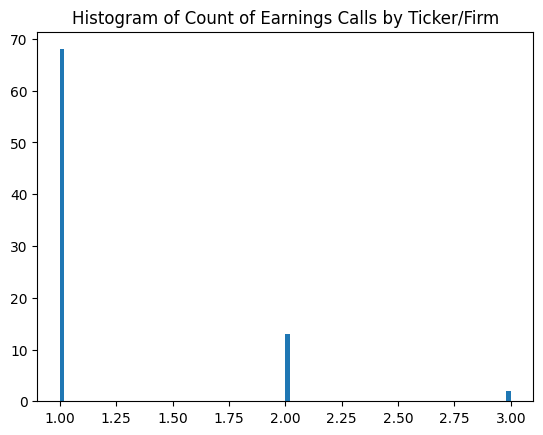

In [34]:
# Histogram of count of earnings calls by ticker/firm
# Title: Histogram of Count of Earnings Calls by Ticker
plt.hist(df['ticker'].value_counts(), bins = 100)
plt.title('Histogram of Count of Earnings Calls by Ticker/Firm')
plt.show()

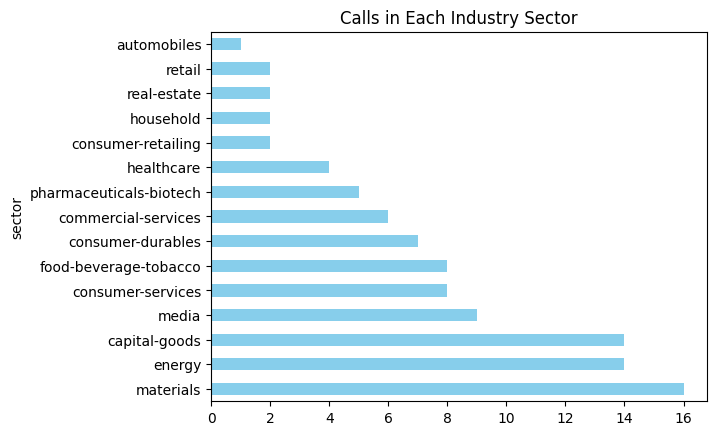

In [35]:
# Distribution of industry sectors
# variable sector
# Title: Calls in Each Industry Sector
df['sector'].value_counts().plot(kind = 'barh', color = 'skyblue')
plt.title('Calls in Each Industry Sector')
plt.show()

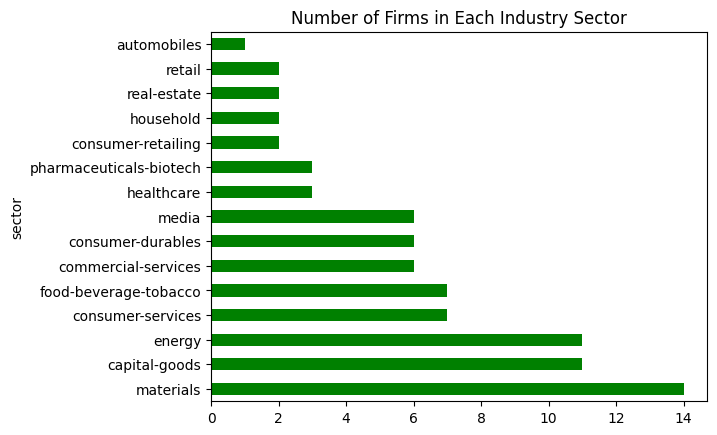

In [36]:
# Number of firms in each industry sector
# Title: Number of Firms in Each Industry Sector
# Unique ticker by sector, sort by number of firms
df.groupby('sector')['ticker'].nunique().sort_values(ascending=False).plot(kind = 'barh', color = 'green')
plt.title('Number of Firms in Each Industry Sector')
plt.show()

/var/folders/2v/664l7ccj4vn7kztqkgv6y7mh0000gn/T/ipykernel_92792/1024513809.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['call_year'] = pd.to_datetime(df['earnings_call_date']).dt.year
/var/folders/2v/664l7ccj4vn7kztqkgv6y7mh0000gn/T/ipykernel_92792/1024513809.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['call_quarter'] = pd.to_datetime(df['earnings_call_date']).dt.quarter


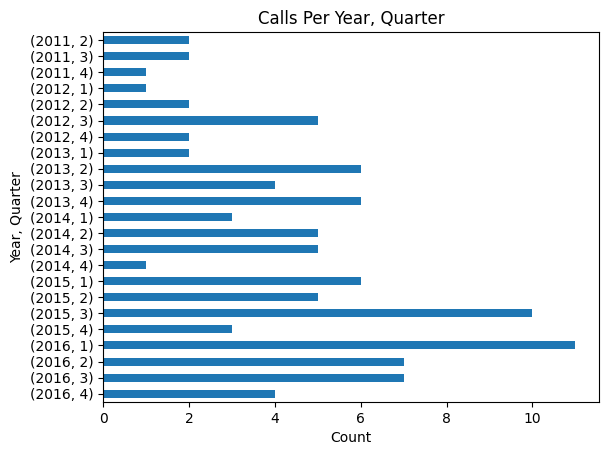

In [37]:
# Distribution of earnings_call_date
# Create call_year and call_quarter columns after converting earnings_call_date to datetime
df['call_year'] = pd.to_datetime(df['earnings_call_date']).dt.year
df['call_quarter'] = pd.to_datetime(df['earnings_call_date']).dt.quarter
# Group by year and quarter
data_grouped = df.groupby([df.call_year, df.call_quarter]).size().sort_index(ascending=False)
# Plot horizontal bar chart
# 2010 at the top
data_grouped.plot(kind='barh')
plt.title('Calls Per Year, Quarter')
plt.xlabel('Count')
plt.ylabel('Year, Quarter')
plt.show()


In [38]:
# Company dropout
# For each ticker, get the max value of earnings_call_date, and print out items where it is not in the last quarter of 2016
# Convert earnings_call_date to datetime
df['earnings_call_date_dt'] = pd.to_datetime(df['earnings_call_date'])
# Add column max_date to df
df['max_date'] = df.groupby('ticker')['earnings_call_date_dt'].transform('max')
# Display rows where max_date is not in the last quarter of 2016
df[df['max_date'] < '2016-10-01']

/var/folders/2v/664l7ccj4vn7kztqkgv6y7mh0000gn/T/ipykernel_92792/2025158213.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['earnings_call_date_dt'] = pd.to_datetime(df['earnings_call_date'])
/var/folders/2v/664l7ccj4vn7kztqkgv6y7mh0000gn/T/ipykernel_92792/2025158213.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['max_date'] = df.groupby('ticker')['earnings_call_date_dt'].transform('max')


,ticker,earnings_call_date,next_earnings_call_date,rating_on_next_earnings_call_date,days_until_next_earnings_call,Rating,Rating Agency Name,rating_date,Source,Rating Rank AAA is 10,...,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link_income_statement,finalLink_income_statement,ticker_earnings_date,call_year,call_quarter,earnings_call_date_dt,max_date
0,RRC,2012-04-27,2012-07-26,BB,90.0,BB,Standard & Poor's Ratings Services,2012-02-24,Supplementary,6,...,-0.34,159563000.0,159563000.0,https://www.sec.gov/Archives/edgar/data/315852...,https://www.sec.gov/Archives/edgar/data/315852...,RRC_2012-04-27,2012,2,2012-04-27,2015-10-29
1,JOUT,2015-05-09,2015-08-11,BBB,94.0,BBB,Standard & Poor's Ratings Services,2015-03-20,Supplementary,7,...,0.12,9982994.0,9982994.0,https://www.sec.gov/Archives/edgar/data/788329...,https://www.sec.gov/Archives/edgar/data/788329...,JOUT_2015-05-09,2015,2,2015-05-09,2015-05-09
2,COST,2013-05-30,2013-10-09,A,132.0,A,Standard & Poor's Ratings Services,2012-08-28,Supplementary,8,...,1.04,436488000.0,440780000.0,https://www.sec.gov/Archives/edgar/data/909832...,https://www.sec.gov/Archives/edgar/data/909832...,COST_2013-05-30,2013,2,2013-05-30,2013-05-30
3,EOG,2014-05-06,2014-08-06,A,92.0,A,Standard & Poor's Ratings Services,2014-03-24,Supplementary,8,...,1.21,542278000.0,548071000.0,https://www.sec.gov/Archives/edgar/data/821189...,https://www.sec.gov/Archives/edgar/data/821189...,EOG_2014-05-06,2014,2,2014-05-06,2014-05-06
4,DVN,2011-05-05,2011-08-03,BBB,90.0,BBB,Standard & Poor's Ratings Services,2011-03-29,Both,7,...,6.48,422000000.0,423000000.0,https://www.sec.gov/Archives/edgar/data/109001...,https://www.sec.gov/Archives/edgar/data/109001...,DVN_2011-05-05,2011,2,2011-05-05,2011-05-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,OEC,2016-03-04,2016-05-06,BB,63.0,BB,Standard & Poor's Ratings Services,2015-11-23,Supplementary,6,...,0.25,59451000.0,59906000.0,NaN,NaN,OEC_2016-03-04,2016,1,2016-03-04,2016-03-04
96,TMO,2016-04-28,2016-07-28,BBB,91.0,BBB,Standard & Poor's Ratings Services,2013-12-09,Supplementary,7,...,1.01,395800000.0,398700000.0,https://www.sec.gov/Archives/edgar/data/97745/...,https://www.sec.gov/Archives/edgar/data/97745/...,TMO_2016-04-28,2016,2,2016-04-28,2016-04-28
97,KMT,2013-10-24,2014-01-30,BBB,98.0,BBB,Standard & Poor's Ratings Services,2013-07-18,Supplementary,7,...,0.64,78718000.0,79744000.0,https://www.sec.gov/Archives/edgar/data/55242/...,https://www.sec.gov/Archives/edgar/data/55242/...,KMT_2013-10-24,2013,4,2013-10-24,2013-10-24
98,ETN,2012-10-31,2013-02-05,A,97.0,A,Standard & Poor's Ratings Services,2011-01-25,Original,8,...,1.02,337600000.0,339800000.0,https://www.sec.gov/Archives/edgar/data/155118...,https://www.sec.gov/Archives/edgar/data/155118...,ETN_2012-10-31,2012,4,2012-10-31,2012-10-31


In [39]:
# Unique firms where this is the case
df[df['max_date'] < '2016-10-01'][['ticker', 'max_date']].drop_duplicates()

,ticker,max_date
0,RRC,2015-10-29
1,JOUT,2015-05-09
2,COST,2013-05-30
3,EOG,2014-05-06
4,DVN,2011-05-05
...,...,...
90,EXPE,2015-07-31
91,CVX,2015-01-30
95,OEC,2016-03-04
97,KMT,2013-10-24


AMCR is amcor, should still exist but it's date is kind of close to the end of 2016

BTU, peabody energy, seems to have gone bankrupt April 13, 2016

FTI underwent a merger in 2016-2017

KBH still exists, but again the date is pretty close...

The other non-close one is STON. Notably, StonMor Partners had some issues with delayed SEC filings https://seekingalpha.com/article/4056108-prelude-to-bankruptcy-saving-grace-stonemor-partners-delays-10-k-again

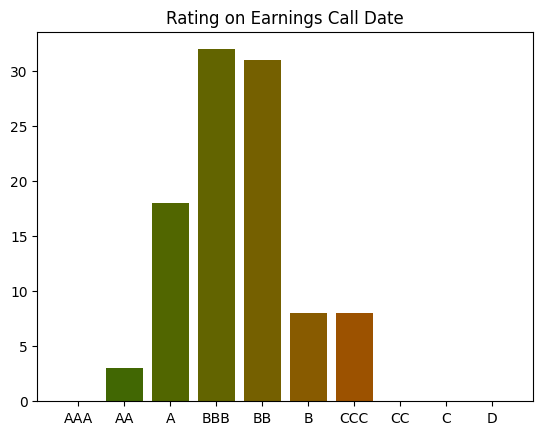

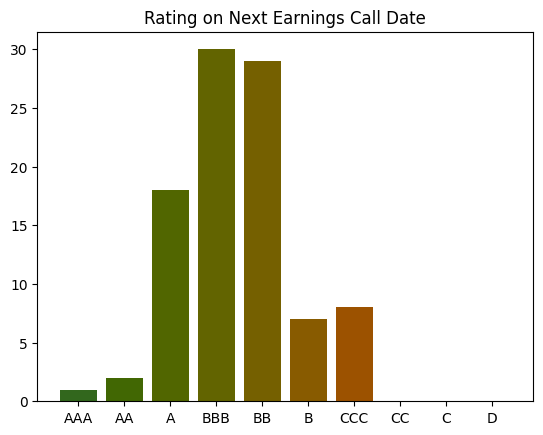

In [40]:
# Distribution of Rating and rating_on_next_earnings_call_date

# Colored with gradient and ordered

# Colors AAA through D
# Used https://colordesigner.io/gradient-generator#google_vignette
# Assign hex codes from green to red
#32671d
#416703
#516600
#626400
#756000
#885b00
#9c5200
#af4500
#c33200
#d60000
hex_code_mapper = {'AAA': '#32671d', 'AA': '#416703', 'A': '#516600', 'BBB': '#626400', 'BB': '#756000', 'B': '#885b00', 'CCC': '#9c5200', 'CC': '#af4500', 'C': '#c33200', 'D': '#d60000'}

# Ordering of bars - keys from hex_code_mapper
bar_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
# Assign values of Rating to this ordering
df['Rating'] = pd.Categorical(df['Rating'], categories=bar_order, ordered=True)

# Create plot
# Save to "../Output/Distribution of Ratings.png"
plt.bar(df['Rating'].value_counts().sort_index().index, df['Rating'].value_counts().sort_index(), color=[hex_code_mapper[i] for i in bar_order])
plt.title('Rating on Earnings Call Date')
#plt.savefig('../../Output/Distribution of Rating Issuances.png')
plt.show()

# Rating on next earnings call date
df['rating_on_next_earnings_call_date'] = pd.Categorical(df['rating_on_next_earnings_call_date'], categories=bar_order, ordered=True)
plt.bar(df['rating_on_next_earnings_call_date'].value_counts().sort_index().index, df['rating_on_next_earnings_call_date'].value_counts().sort_index(), color=[hex_code_mapper[i] for i in bar_order])
plt.title('Rating on Next Earnings Call Date')
#plt.savefig('../../Output/Distribution of Rating on Next Earnings Call Date.png')
plt.show()

/var/folders/2v/664l7ccj4vn7kztqkgv6y7mh0000gn/T/ipykernel_92792/3119831694.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()


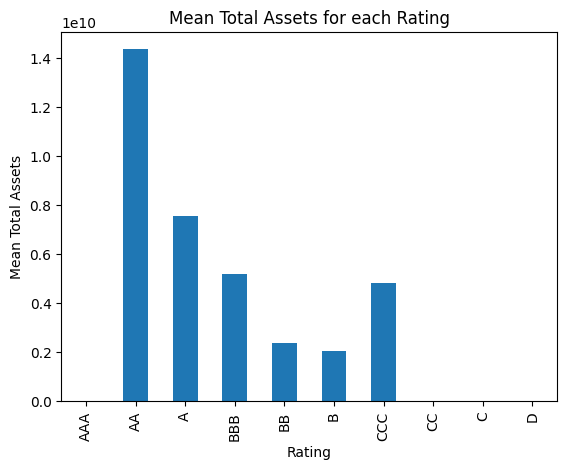

In [41]:
# Calculate the mean of "totalAssets" for each kind of "Rating"
mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Total Assets for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Total Assets')
plt.show()

/var/folders/2v/664l7ccj4vn7kztqkgv6y7mh0000gn/T/ipykernel_92792/796684613.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()


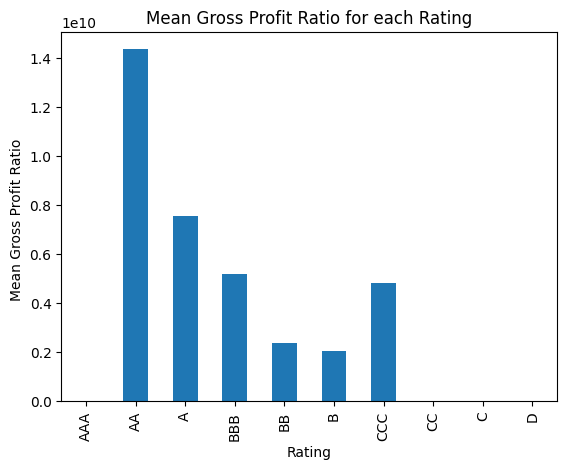

In [42]:
# Calculate the mean of "grossProfitRatio" for each kind of "Rating"
mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Gross Profit Ratio for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Gross Profit Ratio ')
plt.show()

We can see the relationship between rating and total assets; rating and gross profit ratio. High rating like AAA will have high mean total assets and high mean gross profit ratio.

# NLP EDA

Number of records: 100
Average transcript length: 51399.78 characters


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chengzhengxing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chengzhengxing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 10 most common words:
quarter: 5320
year: 4871
think: 4146
million: 3480
going: 2613
business: 2541
growth: 2504
would: 2363
us: 2156
well: 2136


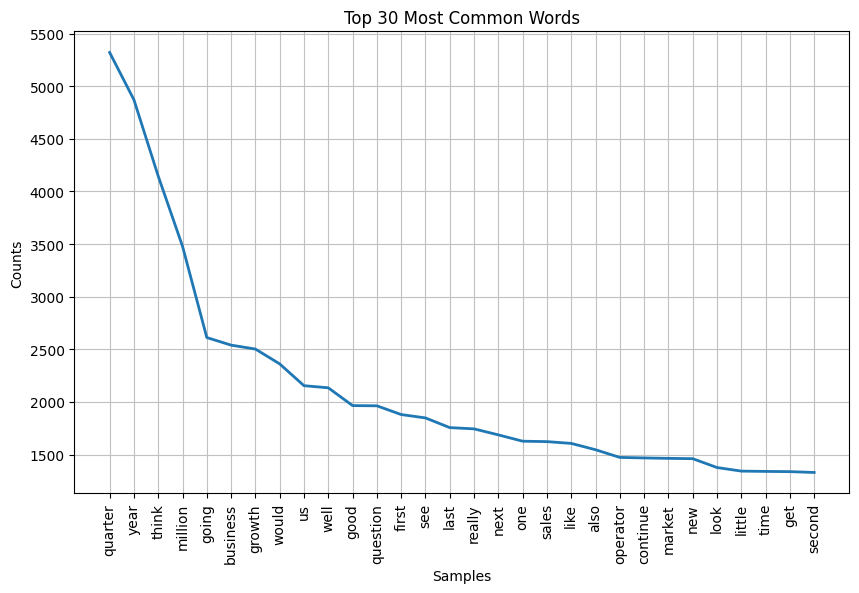

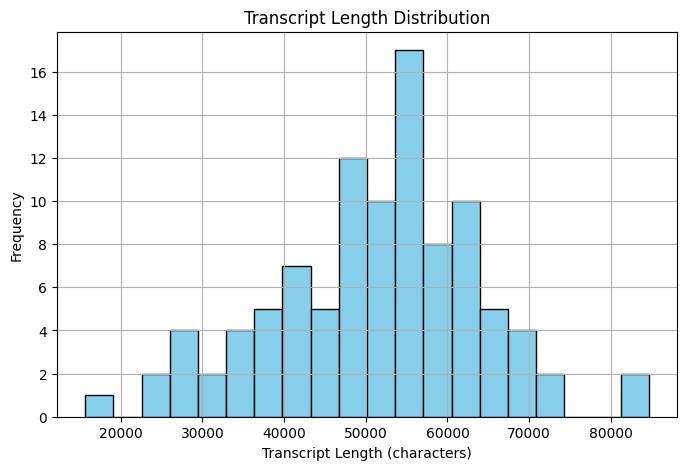

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist


# Basic Statistics
num_records = len(df)
avg_length = df['transcript'].str.len().mean()

print(f"Number of records: {num_records}")
print(f"Average transcript length: {avg_length:.2f} characters")

# Tokenize the text
nltk.download('punkt')  # Download NLTK tokenizer data
tokens = df['transcript'].apply(word_tokenize)

# Remove stop words
nltk.download('stopwords')  # Download NLTK stop words data
stop_words = set(stopwords.words('english'))
tokens = tokens.apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words and word.isalpha()])

# Word Frequency Analysis
all_words = [word.lower() for token_list in tokens for word in token_list]
fdist = FreqDist(all_words)
top_words = fdist.most_common(10)
print("Top 10 most common words:")
for word, freq in top_words:
    print(f"{word}: {freq}")

# Plot Word Frequency Distribution
plt.figure(figsize=(10, 6))
fdist.plot(30, title='Top 30 Most Common Words')

# Text Length Distribution
transcript_lengths = df['transcript'].str.len()
plt.figure(figsize=(8, 5))
plt.hist(transcript_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Transcript Length Distribution')
plt.xlabel('Transcript Length (characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


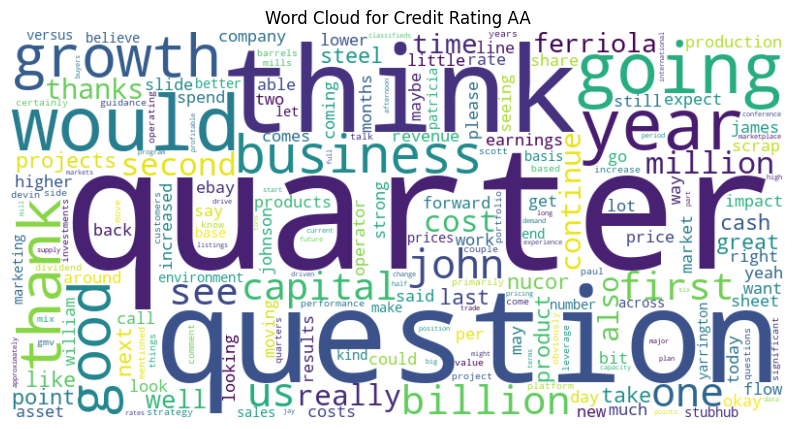

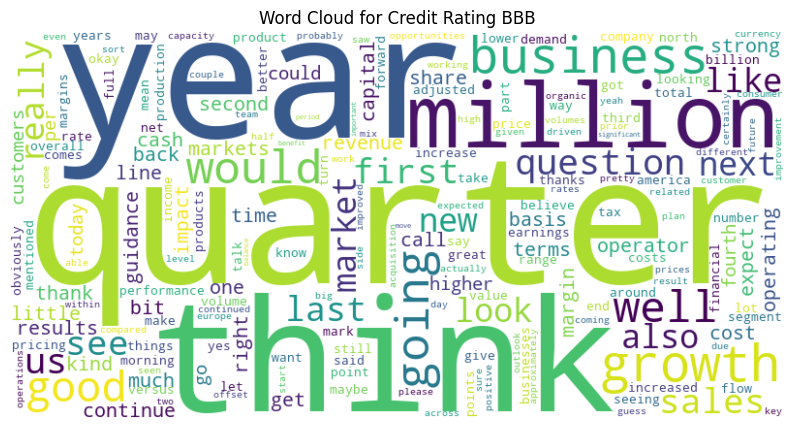

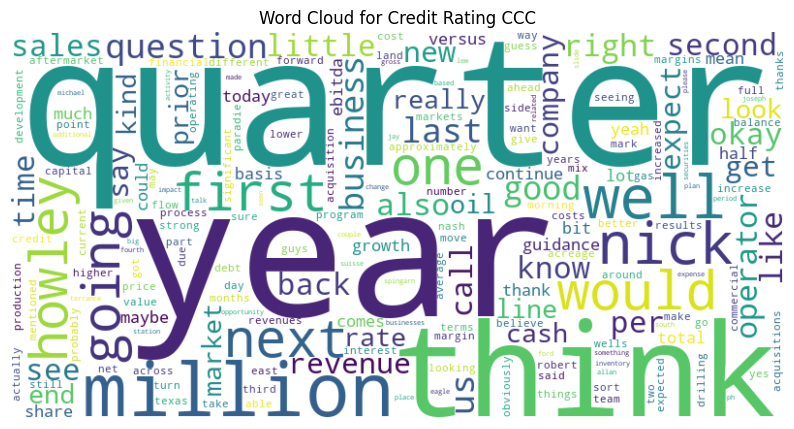

In [44]:
from wordcloud import WordCloud

# Generate word clouds for each credit rating
ratings = ["AA","BBB","CCC"]
for rating in ratings:

    rating_df = df[df['Rating'] == rating]
    tokens = rating_df['transcript'].apply(word_tokenize)
    stop_words = set(stopwords.words('english'))
    tokens = tokens.apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words and word.isalpha()])
    
    all_words = [word.lower() for token_list in tokens for word in token_list]
    fdist = FreqDist(all_words)

    # Generate Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)
    
    # Plot Word Cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Credit Rating {rating}')
    plt.show()

We can see from word cloud for credit rating AA, postive words like "growth" are bigger.